In [1]:
import time
import numpy as np
import pandas as pd
import sys
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
sys.path.append('./core/')
sys.path.append('./core/Modality/')

from Modality.TomatoExtension import TomatoExtension
from ScaleSpace.ScaleSpace import ScaleSpaceTree
from NoiseRemoval.ClusterGMM import gmm_cut
from NoiseRemoval.RemoveNoiseTransformed import remove_noise_tomatoext


# Import data

In [3]:
#fname = 'resources/GaiaSource_000-020-090.csv'
fname = './resources/cluster_data_uppersco_extravel_covmtx.csv'
data = pd.read_csv(fname)

In [4]:
data_axes = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
pos_cols = ['ra', 'dec', 'parallax']

print(data_axes[:3])

c_pos, c_vel = 1, 5   # See infos on scaling in Kerr+2021 (https://arxiv.org/pdf/2105.09338.pdf)

df_cluster = data[data_axes]
df_cluster[['pmra', 'pmdec']] *= c_vel

['ra', 'dec', 'parallax']


/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# Graph and mid point preparation

In [5]:
%%time
max_knn = 70
te = TomatoExtension(df_cluster, max_neighbors=100, beta=0.99, knn_cluster_graph=50, knn_hypotest=20, knn_max=max_knn)

/home/johannes/dev/thesis/topoclust/lodestar-backend/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=100 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


CPU times: user 27.6 s, sys: 616 ms, total: 28.2 s
Wall time: 20 s


In [7]:
%%time
te.update(knn_hypotest=20, knn_cluster_graph=40)
res = te.fit(alpha=0.05)

CPU times: user 11.7 s, sys: 161 ms, total: 11.9 s
Wall time: 4.65 s


In [8]:
# Clusters
np.unique(res, return_counts=True)

(array([  2,  10,  18,  19,  21,  22,  25,  27,  30,  33,  41,  45,  51,
         55,  58,  59,  66,  67,  68,  70,  72,  74,  75,  76,  80,  84,
         91,  93,  94,  96,  97,  98,  99, 101, 105, 108, 110, 111, 120,
        123, 128, 129, 133, 134, 135, 137, 140, 142, 145, 146, 152, 153,
        155, 156, 157, 160, 163, 166, 167, 169, 177, 178, 179, 184, 188,
        193, 196, 198, 199, 203, 205, 206]),
 array([1623,  158,  609, 2223,  126, 1300,  141,  164,  346,   56,  623,
         875, 1320,  100,  212,  154, 1214, 1005,   78, 1927,   71,  169,
         171,  238,  295, 1159,  254,  855,  127,  291, 1827,  398,  402,
         612,  158,  720, 1594,  175, 2264,   75, 1527, 3750,  429,  240,
         245, 1629,  809,  699,  349,   97,  682, 1087, 1104,  581,  296,
         262,   27,  272,  684,  340,  106,  153,  325,  466,  733,  246,
         643, 1623,  203,  162,  346,  269]))

## Remove noise in new setting

In [9]:
from sklearn.neighbors import kneighbors_graph

ajm_knn = kneighbors_graph(df_cluster, n_neighbors=10, include_self=True, n_jobs=-1)

In [10]:
clustering_res = -np.ones(data.shape[0])

for uid in np.unique(res):
    print(f'Removing noise from cluster {uid}')
    ba, good_cluster = remove_noise_tomatoext(
        data=df_cluster,
        cluster_bool_arr=res == uid, 
        te_obj=te, 
        pos_cols=pos_cols,
        nb_neigh_denstiy=10,
        data_full=data, 
        ra_col='ra', dec_col='dec', plx_col='parallax', pmra_col='pmra', pmdec_col='pmdec',
        rv_col='dr2_radial_velocity', rv_err_col='dr2_radial_velocity_error', uvw_cols=['u', 'v', 'w'],
        adjacency_mtrx=ajm_knn, 
        radius=8,
        min_cluster_size=10
    )
    if good_cluster:
        clustering_res[ba] = uid
        print(f'{np.sum(ba)} part of cluster')
        print(f'{30 * "-"}')

Removing noise from cluster 2


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


18 part of cluster
------------------------------
Removing noise from cluster 10


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


82 part of cluster
------------------------------
Removing noise from cluster 18


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


273 part of cluster
------------------------------
Removing noise from cluster 19


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


311 part of cluster
------------------------------
Removing noise from cluster 21


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


21 part of cluster
------------------------------
Removing noise from cluster 22


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


665 part of cluster
------------------------------
Removing noise from cluster 25


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


42 part of cluster
------------------------------
Removing noise from cluster 27


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


20 part of cluster
------------------------------
Removing noise from cluster 30


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


20 part of cluster
------------------------------
Removing noise from cluster 33


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 41


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


14 part of cluster
------------------------------
Removing noise from cluster 45


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


454 part of cluster
------------------------------
Removing noise from cluster 51


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


24 part of cluster
------------------------------
Removing noise from cluster 55


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


11 part of cluster
------------------------------
Removing noise from cluster 58


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


59 part of cluster
------------------------------
Removing noise from cluster 59


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


61 part of cluster
------------------------------
Removing noise from cluster 66


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


53 part of cluster
------------------------------
Removing noise from cluster 67


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


24 part of cluster
------------------------------
Removing noise from cluster 68


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 70


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


498 part of cluster
------------------------------
Removing noise from cluster 72


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


11 part of cluster
------------------------------
Removing noise from cluster 74


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 75


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 76


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


91 part of cluster
------------------------------
Removing noise from cluster 80


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 84


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


147 part of cluster
------------------------------
Removing noise from cluster 91


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


34 part of cluster
------------------------------
Removing noise from cluster 93


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


401 part of cluster
------------------------------
Removing noise from cluster 94


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


40 part of cluster
------------------------------
Removing noise from cluster 96


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 97


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 98


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


189 part of cluster
------------------------------
Removing noise from cluster 99


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


51 part of cluster
------------------------------
Removing noise from cluster 101


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


114 part of cluster
------------------------------
Removing noise from cluster 105


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


14 part of cluster
------------------------------
Removing noise from cluster 108


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


202 part of cluster
------------------------------
Removing noise from cluster 110


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 111


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


90 part of cluster
------------------------------
Removing noise from cluster 120


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


640 part of cluster
------------------------------
Removing noise from cluster 123


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


11 part of cluster
------------------------------
Removing noise from cluster 128


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


496 part of cluster
------------------------------
Removing noise from cluster 129


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


337 part of cluster
------------------------------
Removing noise from cluster 133


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 134


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


157 part of cluster
------------------------------
Removing noise from cluster 135


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


155 part of cluster
------------------------------
Removing noise from cluster 137


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


301 part of cluster
------------------------------
Removing noise from cluster 140


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


102 part of cluster
------------------------------
Removing noise from cluster 142


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


132 part of cluster
------------------------------
Removing noise from cluster 145


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


174 part of cluster
------------------------------
Removing noise from cluster 146


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 152


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


29 part of cluster
------------------------------
Removing noise from cluster 153


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


15 part of cluster
------------------------------
Removing noise from cluster 155


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


363 part of cluster
------------------------------
Removing noise from cluster 156


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 157


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 160


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


18 part of cluster
------------------------------
Removing noise from cluster 163
10 part of cluster
------------------------------
Removing noise from cluster 166


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs
./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


14 part of cluster
------------------------------
Removing noise from cluster 167


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


191 part of cluster
------------------------------
Removing noise from cluster 169


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 177


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


12 part of cluster
------------------------------
Removing noise from cluster 178


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


31 part of cluster
------------------------------
Removing noise from cluster 179


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


87 part of cluster
------------------------------
Removing noise from cluster 184


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


91 part of cluster
------------------------------
Removing noise from cluster 188


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


64 part of cluster
------------------------------
Removing noise from cluster 193


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


Removing noise from cluster 196


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


160 part of cluster
------------------------------
Removing noise from cluster 198


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


536 part of cluster
------------------------------
Removing noise from cluster 199


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


34 part of cluster
------------------------------
Removing noise from cluster 203


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


79 part of cluster
------------------------------
Removing noise from cluster 205


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


223 part of cluster
------------------------------
Removing noise from cluster 206


./core/NoiseRemoval/RemoveNoiseTransformed.py:57: RuntimeWarning: invalid value encountered in less
  rv_isnan_or_large_err = np.isnan(rv) | (np.abs(rv / rv_err) < 2)  # for large errors find better suited rvs


83 part of cluster
------------------------------


# Plot clusters

In [11]:
cs = clustering_res  #fc_noise_removed  # cs_renamed

print(cs.tolist())

df_plot = data.loc[cs!=-1].reset_index(drop=True)
clustering_solution = cs.astype(int)
clustering_solution = clustering_solution[clustering_solution!=-1]
cut_us = np.random.uniform(0,1,size=clustering_solution.shape[0])<0.1


bg_opacity = 0.1
bg_color = 'grey'
plt_colors = [
    '#636EFA',
    '#EF553B',
    '#00CC96',
    '#AB63FA',
    '#FFA15A',
    '#19D3F3',
    '#FF6692',
    '#B6E880',
    '#FF97FF',
    '#FECB52',
    '#B82E2E',
    '#316395'
]


# Create figure
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "scatter3d"}, {"type": "xy"}, {"type": "xy"}]],
    column_widths=[0.5, 0.3, 0.2],
    subplot_titles=[
        'Galactic position', 
        'Tangential velocity', 
        'HRD'
    ],

)

# --------------- 3D scatter plot -------------------
trace_3d_bg = go.Scatter3d(
    x=df_plot.loc[cut_us, 'X'], y=df_plot.loc[cut_us, 'Y'], z=df_plot.loc[cut_us, 'Z'],
    mode='markers',
    marker=dict(size=1, color=bg_color,
                opacity=bg_opacity
               ),
    hoverinfo='none',
    showlegend=False,
)
fig.add_trace(trace_3d_bg, row=1, col=1)

trace_sun = go.Scatter3d(
    x=np.zeros(1), y=np.zeros(1), z=np.zeros(1),
    mode='markers',
    marker=dict(size=5, color='red',
                symbol='x'
               ),
    hoverinfo='none',
    showlegend=True,
    name='Sun'
)

fig.add_trace(trace_sun, row=1, col=1)

# trace_hrd_isochrone = go.Scatter(
#     x=coords[:,0], y=coords[:,1],
#     mode='lines',
#     marker=dict(line_width=0.5, color='black',
#                 opacity=0.3
#                ),
#     hoverinfo='none',
#     showlegend=True,
#     name='50 My'
# )
# fig.add_trace(trace_hrd_isochrone, row=1, col=3)




for i, uid in enumerate(np.unique(clustering_solution)):
    if uid!=-1:
        plot_points = (clustering_solution==uid) #& cut_us
        trace_3d = go.Scatter3d(
            x=df_plot.loc[plot_points, 'X'], y=df_plot.loc[plot_points, 'Y'], z=df_plot.loc[plot_points, 'Z'],
            mode='markers',
            marker=dict(size=1, color=plt_colors[i%len(plt_colors)]),
            hoverinfo='none',
            showlegend=True,
            name=f'Cluster {int(uid)} ({np.sum(plot_points)} stars)',
            legendgroup=f'group-{uid}',
        )
        fig.add_trace(trace_3d, row=1, col=1)
# --------------- 2D vel plot -------------------
trace_vel_bg = go.Scatter(
    x=df_plot.loc[cut_us, 'v_alpha'], y=df_plot.loc[cut_us, 'v_delta'],
    mode='markers',
    marker=dict(size=3, color=bg_color,
                opacity=bg_opacity
               ),
    hoverinfo='none',
    showlegend=False
)
fig.add_trace(trace_vel_bg, row=1, col=2)

for i, uid in enumerate(np.unique(clustering_solution)):
    if uid!=-1:
        plot_points = (clustering_solution==uid) #& cut_us
        trace_vel = go.Scatter(
            x=df_plot.loc[plot_points, 'v_alpha'], y=df_plot.loc[plot_points, 'v_delta'],
            mode='markers',
            marker=dict(size=3, color=plt_colors[i%len(plt_colors)], 
                     #colorscale='inferno',
                     #opacity=,
                    ),
            hoverinfo='none',
            legendgroup=f'group-{uid}',
            name=f'Cluster {uid} ({np.sum(plot_points)} stars)',
            showlegend=False
        )
        fig.add_trace(trace_vel, row=1, col=2)


# --------------- HRD plot -------------------
trace_hrd_bg = go.Scatter(
    x=df_plot.loc[cut_us, 'g_rp'], y=df_plot.loc[cut_us, 'mag_abs_g'],
    mode='markers',
    marker=dict(size=3, color=bg_color,
                opacity=bg_opacity
               ),
    hoverinfo='none',
    showlegend=False
)
fig.add_trace(trace_hrd_bg, row=1, col=3)

for i, uid in enumerate(np.unique(clustering_solution)):
    if uid!=-1:
        plot_points = (clustering_solution==uid) #& cut_us
        trace_hrd = go.Scatter(
            x=df_plot.loc[plot_points, 'g_rp'], y=df_plot.loc[plot_points, 'mag_abs_g'],
            mode='markers',
            marker=dict(size=3, color=plt_colors[i%len(plt_colors)], 
                     #colorscale='inferno',
                     #opacity=,
                    ),
            hoverinfo='none',
            legendgroup=f'group-{uid}',
            name=f'Cluster {uid} ({np.sum(plot_points)} stars)',
            showlegend=False
        )
        fig.add_trace(trace_hrd, row=1, col=3)



# ------------ Update axis information ---------------
# 3d position
plt_kwargs = dict(showbackground=False, showline=False, zeroline=True, zerolinecolor='grey', zerolinewidth=2, 
                  showgrid=True, showticklabels=True, 
                  linecolor='black', linewidth=1,  gridcolor='rgba(100,100,100,0.5)')

xaxis=dict(**plt_kwargs, title='X [pc]') #, tickmode = 'linear', dtick = 50, range=[-50,200])
yaxis=dict(**plt_kwargs, title='Y [pc]') #, tickmode = 'linear', dtick = 50, range=[-200, 50])
zaxis=dict(**plt_kwargs, title='Z [pc]') #, tickmode = 'linear', dtick = 50, range=[-100, 150])
# tangential vel
fig.update_xaxes(title_text="v_alpha", showgrid=False, row=1, col=2)
fig.update_yaxes(title_text="v_delta", showgrid=False, row=1, col=2)
# tangential vel
fig.update_xaxes(title_text="G-RP", showgrid=False, row=1, col=3)
fig.update_yaxes(title_text="Abs mag G", showgrid=False, autorange="reversed", row=1, col=3)


# Finalize layout
fig.update_layout(
    title="",
    #width=800,
    height=800,
    showlegend=True,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend= dict(itemsizing='constant'),
    # 3D plot
    scene=dict(
        xaxis=dict(xaxis),
        yaxis=dict(yaxis),
        zaxis=dict(zaxis)
    )
)


fig.write_html(f"tomato_ext_latest_plot.html")

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 128.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 140.0, -1.0, -1.0, -1.0, -1.0, -1.0, 93.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 167.0, -1.0, -1.0, 93.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 128.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 167.0, -1.0, -1.0, -1.0, 205.0, 128.0, 140.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 167.0, 184.0, 70.0, -1.0, -1.0, 206.0, 206.0, -1.0, -1.0, -1.0, -1.0, -1.0, 59.0, -1.0, -1.0, 108.0, -1.0, -1.0, -1.0, 203.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 206.0, -1.0, 140.0, -1.0, -1.0, -1.0, -1.0, 128.0, 140.0, -1.0, 196.0, 70.0, -1.0, -1.0, -1.0, 128.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 93.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 128.0, -1.0, 128.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 167.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 196.0

# Construct scale space

In [24]:
sst = ScaleSpaceTree(data_size=data.shape[0], min_jaccard_sim=0.5)

alpha = 0.01
data_idx = np.arange(data.shape[0])
knn_densities_ssp = np.arange(10,100,2)

for i, nb_neighs in enumerate(knn_densities_ssp):
    st = time.time()
    print(f'Number of neighbors: {nb_neighs}', end=' ')
    # Add level to scale space
    te.update(nb_neighs)
    res = te.fit(alpha=alpha)
    
    modes = {uid: data_idx[res==uid][np.argmax(te.t.weights_[res==uid])] for uid in np.unique(res)}
    
    part = {modes[uid]: data_idx[res==uid] for uid in np.unique(res)}

    for key in part.keys():
      print(key)
      print(str(part[key]) + "\n")

    sst.next_scale(partitions=part)
    print(f'- level {i} took {time.time()-st:.2f} sec')

18623
[    3    16    19 ... 46490 46491 46492]

25207
[ 2212  2963  3175  4393  5542 14104 14623 16239 16760 16785 17695 17776
 17792 18176 18266 18566 18568 18575 18578 18605 18632 18658 19152 19259
 19265 19532 19602 19632 19635 19724 19726 19742 19747 19749 19750 19775
 19776 19787 19790 19798 19804 19806 19860 19869 19917 20066 20074 20109
 20126 20145 20163 20183 20348 20656 20687 20688 20735 20741 20764 20773
 20789 20813 20836 20859 20866 20867 20876 20879 20880 20881 20886 20888
 20904 20905 20918 20979 20989 21030 21069 21079 21082 21086 21099 21102
 21107 21109 21110 21111 21112 21125 21208 21219 21220 21233 21235 21270
 21382 21576 21578 21583 21585 21586 21590 21591 21598 21602 21606 21608
 21610 21612 21613 21774 21796 21800 21802 21804 21810 21811 21812 21823
 21828 21829 21976 21977 21978 21980 21983 21986 22014 22018 22023 22054
 22056 22063 22067 22073 22077 22081 22085 22104 22111 22112 22117 22124
 22125 22129 22135 22136 22141 22145 22151 22152 22159 22167 22413 22

In [20]:
ssp_clusters = sst.scale_space_clusters

node_level_clusters = {}

G_ssp = nx.Graph()
G_ssp.add_nodes_from(ssp_clusters.keys())
for cli in ssp_clusters.keys():
    node_level_clusters[cli] = [int(ssp_clusters[cli].level_id), int(ssp_clusters[cli].nb_points), ssp_clusters[cli].index_arr.tolist()]
    for child in ssp_clusters[cli].child_list:
        G_ssp.add_edge(cli, child)
        
print(node_level_clusters)
dict(G_ssp.edges.keys())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{0: 40,
 1: 43,
 2: 42,
 3: 43,
 4: 45,
 5: 42,
 6: 47,
 7: 42,
 8: 48,
 9: 49,
 10: 48,
 11: 77,
 12: 69,
 13: 52,
 14: 75,
 15: 77,
 16: 57,
 17: 58,
 18: 74,
 19: 73,
 20: 68,
 21: 60,
 22: 63,
 23: 64,
 24: 66,
 25: 67,
 26: 68,
 27: 69,
 28: 70,
 29: 70,
 30: 71,
 31: 74,
 32: 69,
 33: 76,
 34: 77,
 35: 50,
 36: 48,
 37: 77,
 38: 78,
 39: 73,
 40: 80,
 41: 111,
 42: 83,
 43: 84,
 44: 89,
 45: 85,
 46: 86,
 47: 87,
 48: 83,
 49: 88,
 50: 89,
 51: 83,
 52: 90,
 53: 83,
 54: 91,
 55: 111,
 56: 93,
 57: 95,
 58: 96,
 59: 97,
 60: 99,
 61: 101,
 62: 83,
 63: 100,
 64: 101,
 65: 106,
 66: 102,
 67: 103,
 68: 98,
 69: 105,
 70: 106,
 71: 107,
 72: 109,
 73: 111,
 74: 97,
 75: 110,
 76: 111,
 77: 113,
 78: 114,
 79: 115,
 80: 120,
 81: 142,
 82: 116,
 83: 117,
 84: 118,
 85: 119,
 86: 120,
 87: 121,
 88: 122,
 89: 117,
 90: 123,
 91: 124,
 92: 126,
 93: 130,
 94: 127,
 95: 117,
 96: 128,
 97: 145,
 98: 131,
 99: 132,
 100: 135,
 101: 134,
 102: 137,
 103: 138,
 104: 139,
 105: 140,
 106: 

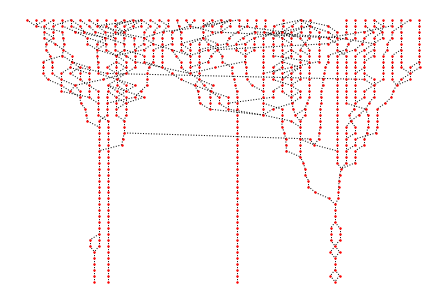

In [33]:
# Might have to call the function multiple times since different connected components might overlap
pos = graphviz_layout(G_ssp, prog="dot", )
nx.draw(G_ssp, pos, node_size=2, node_color='r', font_size=0, style="dotted")

plt.show()